<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

Dask and XGBoost
=======================

<img src="https://raw.githubusercontent.com/dmlc/dmlc.github.io/master/img/logo-m/xgboost.png"
     align="left"
     width="15%"
     alt="XGBoost logo">


In [1]:
from dask import compute, persist
from dask.distributed import Client, progress

client = Client('172.31.33.0:8786')
client

<Client: scheduler='tcp://172.31.33.0:8786' processes=10 cores=80>

## Load the Data

In [2]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('s3://dask-data/airline-data/20*.csv', usecols=cols,
                  storage_options={'anon': True})

df = df.sample(frac=0.2) # we blow out ram otherwise

is_delayed = (df.DepDelay.fillna(16) > 15)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)

In [3]:
df.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance
136958,2000,1,3,1930,WN,AUS,MCO,993
453570,2000,1,3,1630,CO,EWR,DCA,199
509727,2000,2,1,1605,WN,PHX,SAN,304
200370,2000,1,3,1800,CO,EWR,ORD,719
132313,2000,1,1,1543,AA,DFW,MCI,460


In [4]:
is_delayed.head()

136958    False
453570    False
509727    False
200370     True
132313     True
Name: DepDelay, dtype: bool

## One hot encode

In [5]:
df2 = dd.get_dummies(df.categorize()).persist()

In [6]:
len(df2.columns)

683

In [7]:
df2.head()

,Year,Month,DayOfWeek,CRSDepTime,Distance,UniqueCarrier_WN,UniqueCarrier_CO,UniqueCarrier_AA,UniqueCarrier_US,UniqueCarrier_NW,...,Dest_BJI,Dest_INL,Dest_ROW,Dest_PIR,Dest_RKS,Dest_GCC,Dest_CYS,Dest_MKG,Dest_LMT,Dest_OTH
136958,2000,1,3,1930,993,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
453570,2000,1,3,1630,199,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509727,2000,2,1,1605,304,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200370,2000,1,3,1800,719,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132313,2000,1,1,1543,460,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split and Train

We split our data randomly in a 90%/10% split for training and testing.

We pull parameters from [this similar experiment](https://github.com/szilard/benchm-ml/blob/master/3-boosting/6-xgboost.R#L28-L32).

We then set up XGBoost and hand data off for training

In [8]:
data_train, data_test = df2.random_split([0.9, 0.1], 
                                         random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], 
                                                    random_state=1234)

In [9]:
%%time
import dask_xgboost as dxgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1}

bst = dxgb.train(client, params, data_train, labels_train)
bst

CPU times: user 456 ms, sys: 25 ms, total: 481 ms
Wall time: 6min 6s


In [10]:
bst

## Predict and Evaluate

We get back a normal XGBoost model.  We can hand it normal Pandas data or use dask-xgboost again to predict against our hold-out testing data.

We numerically evaluate the result using ROC utilities from Scikit-learn

In [11]:
# Use normal XGBoost model with normal Pandas
import xgboost as xgb
dtest = xgb.DMatrix(data_test.head())
bst.predict(dtest)

array([ 0.46952611,  0.47763255,  0.46820614,  0.46959108,  0.47091401], dtype=float32)

In [12]:
# Or use dask-xgboost to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions.head()

132313    0.469526
288044    0.477633
103834    0.468206
134648    0.469591
237994    0.470914
Name: predictions, dtype: float32

In [13]:
predictions

Dask Series Structure:
npartitions=93
None    float32
None        ...
         ...   
None        ...
None        ...
Name: predictions, dtype: float32
Dask Name: _predict_part, 93 tasks

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(labels_test.compute(), 
                    predictions.compute()))

0.695651118777


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())

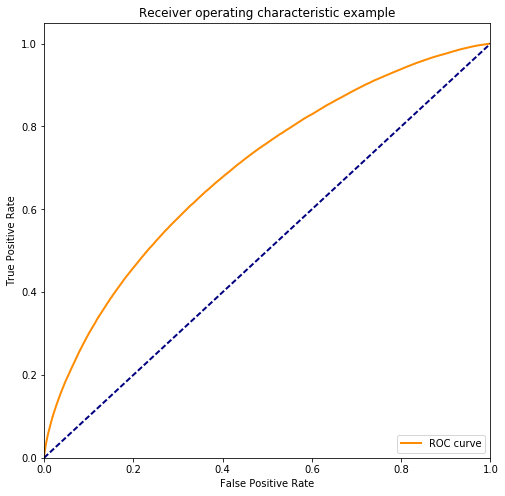

In [17]:
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
